In [6]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from chatgpt_util_imports import generate_dataset
from data_util import clean_data, onehot_decode, onehot_encode, PatchDataset
from models import AE, MixedAE, VAE
from train import collect_embeddings, load_checkpoint, print_loss_metrics, save_checkpoint, train_one_epoch, validate
from util import get_date_and_time

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [8]:
# Load +31k patches as compiled by `bwhitman` for `learnfm`.
fpath = 'data/compact.bin'

df = generate_dataset(fpath)
df = pd.DataFrame(df)
df = clean_data(df)
df = onehot_encode(df)

dataset = PatchDataset(df)

print(f"Num patches: {dataset.df.shape[0]}")
print(f"Num features: {dataset.df.shape[1]}")

Num patches: 30810
Num features: 227


In [9]:
p_train = 0.8
batch_size = 128

n_train = int(p_train * len(dataset))
n_val = len(dataset) - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [10]:
dimensions = [128, 128, 64, 64, 64, 32, 32, 32, 32]
model_type = 'mixed_ae'

n_features = len(dataset._parameter_names)
n_latent = dimensions[-1]

if model_type == 'ae':
    model = AE(n_features, *dimensions)
elif model_type == 'mixed_ae':
    model = MixedAE(n_features, *dimensions)
elif model_type == 'vae':
    model = VAE(n_features, *dimensions)

model = model.to(device)

In [ ]:
# Training.
n_epochs = 1000
lr = 1e-3

checkpoint_dir = 'checkpoints/'
save_interval_epochs = 10
plot_interval_epochs = 25

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

best_loss = np.inf
train_loss = []
val_loss = []
for j in range(n_epochs):
    epoch_train_loss = train_one_epoch(model, train_loader, optimizer, device, model_type)
    epoch_val_loss = validate(model, val_loader, device, model_type)
    scheduler.step(epoch_val_loss)

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

    clear_output(wait=True)

    print(f"Epoch {j}")
    print_loss_metrics(epoch_train_loss, epoch_val_loss)

    if j % plot_interval_epochs == 0:
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.legend()
        plt.show()


    if j % save_interval_epochs != 0:
        continue

    if epoch_val_loss < best_loss:
        fname = f"chkpnt_{get_date_and_time()}_epoch{j}.pt"
        fpath = os.path.join(checkpoint_dir, fname)

        save_checkpoint(model, optimizer, fpath)

        print("=" * 80)
        print(f"Saved checkpoint at: {fpath}")
        print("=" * 80)

        best_loss = epoch_val_loss

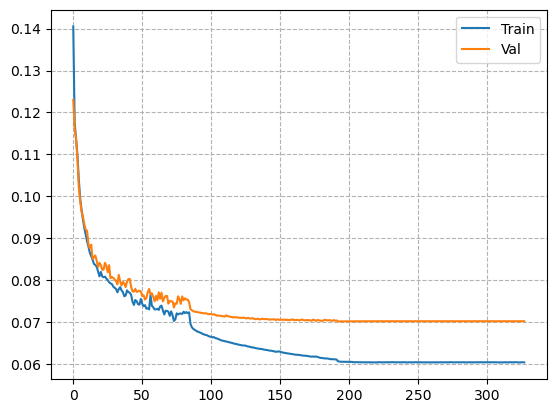

In [12]:
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Val")
plt.grid(True, which="both", ls="--", c='0.7')
plt.legend()
plt.show()

In [14]:
# fpath = 'checkpoints/chkpnt_20231018_063837_epoch490.pt'
# load_checkpoint(fpath, model, optimizer)
model.eval()

restore = dataset.get_restorer()

# Sample first 16 patches and their reconstructions.
patches = []
with torch.no_grad():
    for j, x in enumerate(dataset):
        x = x.to(device)

        if model_type == 'vae':
            y, mu, log_var = model(x)
        elif model_type == 'ae':
            y, z = model(x)
        elif model_type == 'mixed_ae':
            y, z = model(x)

        x = x.to('cpu')
        y = y.to('cpu')

        x = restore(x)
        y = restore(y)

        x = onehot_decode(x)
        y = onehot_decode(y)

        x['VOICE NAME'] = f"x{j}"
        y['VOICE NAME'] = f"y{j}"

        patches.append(x)
        patches.append(y)

        if j >= 15:
            break

In [16]:
from chatgpt_util_imports import make_cartridge

fpath = "data/test.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)

In [17]:
# fpath = 'checkpoints/chkpnt_20231018_063837_epoch490.pt'
# load_checkpoint(fpath, model, optimizer)

embeddings = collect_embeddings(model, dataset, device, model_type)

In [18]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
result = pca.fit_transform(embeddings)

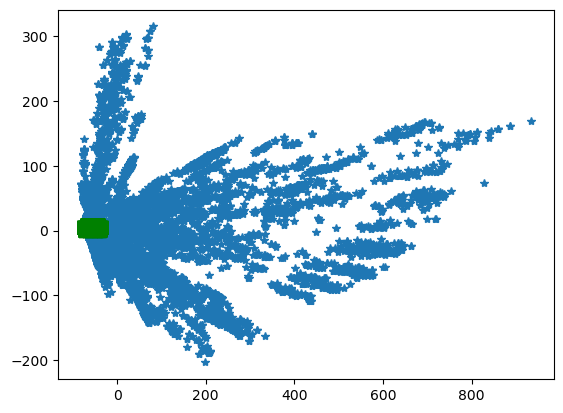

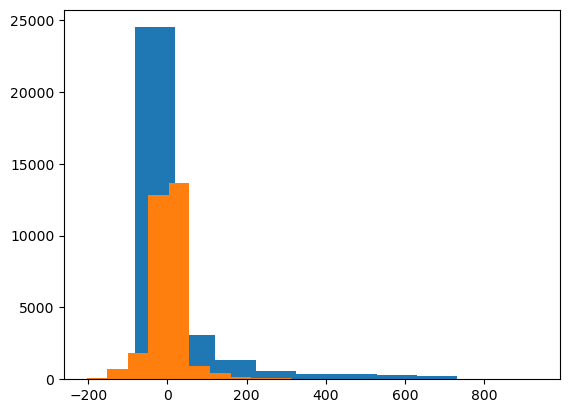

In [38]:
meds = np.median(result, axis=0)
stds = np.std(result, axis=0)

mins = meds - stds / 5.0
maxs = meds + stds / 5.0

n_steps = 100

grid = np.empty((n_steps, n_components))

for j in range(n_components):
    grid[:, j] = np.linspace(mins[j], maxs[j], n_steps)

plt.plot(result[:, 0], result[:, 1], '*')
for j in range(n_steps):
    plt.plot(grid[:, 0], grid[j, 1].repeat(n_steps), '*g')
plt.show()

plt.hist(result[:, 0])
plt.hist(result[:, 1])
plt.show()

In [39]:
grid_embeddings = np.empty((n_steps, n_steps, n_latent))

for j in range(n_steps):
    for j in range(n_steps):
        z = pca.inverse_transform((grid[j, 0], grid[j, 1]))
        grid_embeddings[j, j, :] = z

In [40]:
patches = []
middle_idx = n_steps // 2 - 1

with torch.no_grad():
    for j in range(n_steps):
        z = grid_embeddings[j, middle_idx, :]
        z = torch.Tensor(z).to(device)

        x = model.decode(z).cpu()
        x = restore(x)
        x = onehot_decode(x)

        x['VOICE NAME'] = f"{j}, {middle_idx}"

        patches.append(x)
    for j in range(n_steps):
        z = grid_embeddings[middle_idx, j, :]
        z = torch.Tensor(z).to(device)

        x = model.decode(z).cpu()
        x = restore(x)
        x = onehot_decode(x)

        x['VOICE NAME'] = f"{middle_idx}, {j}"
        patches.append(x)

In [31]:
fpath = "data/pca_grid.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)

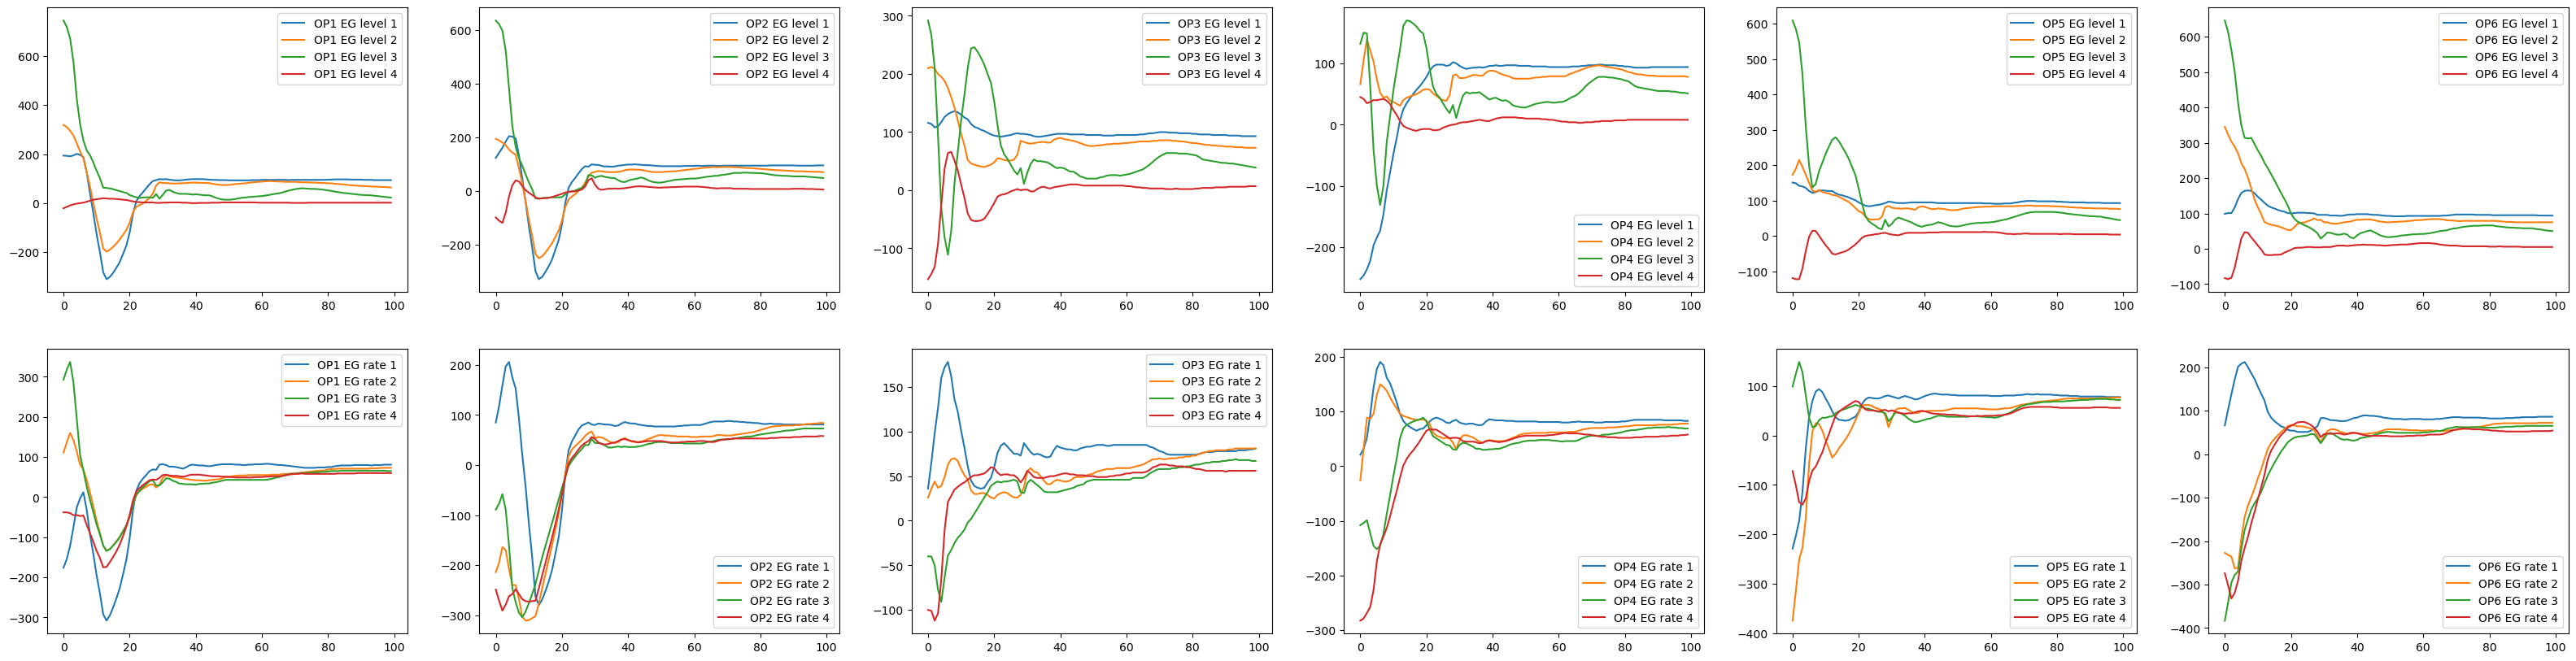

In [85]:
sample = pd.DataFrame(patches)

plt.figure(figsize=(40, 10))
for i in range(12):
    plt.subplot(2, 6, i + 1)

    param = "level" if i < 6 else "rate"
    for j in range(1, 5):
        key = f"OP{(i % 6) + 1} EG {param} {j}"
        plt.plot(sample[key][:100], label=key)
    plt.legend()
plt.show()

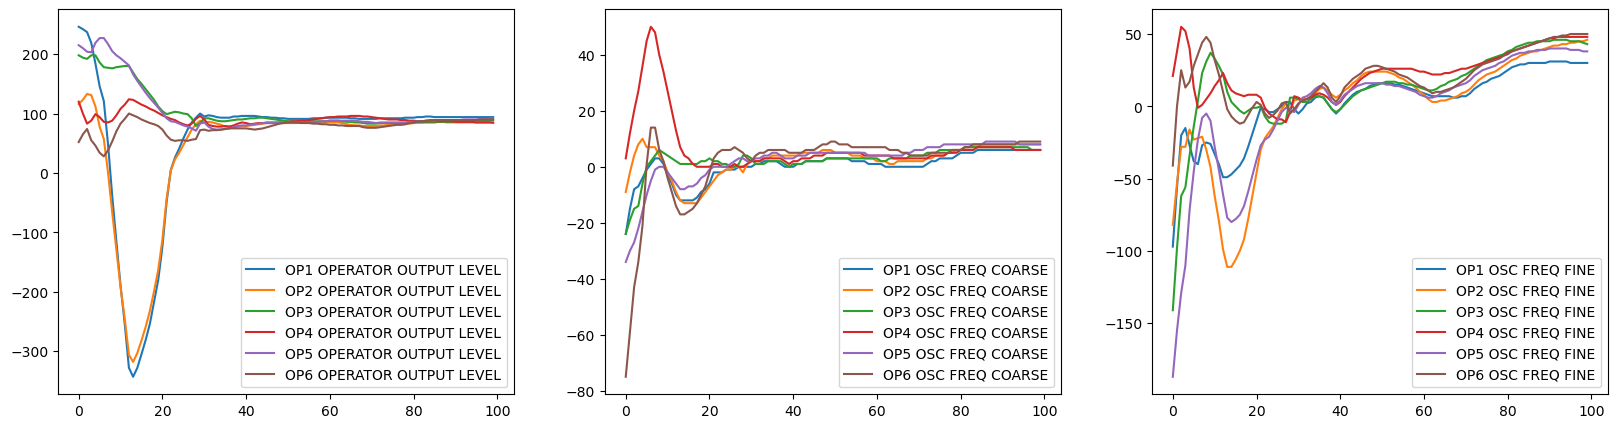

In [93]:
plt.figure(figsize=(20, 5))
params = ['OPERATOR OUTPUT LEVEL','OSC FREQ COARSE', 'OSC FREQ FINE']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for j in range(6):
        key = f"OP{j + 1} {params[i]}"
        plt.plot(sample[key][:100], label=key)
    plt.legend()
plt.show()